In [546]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import accuracy_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_palette("GnBu_d")
sns.set_style('whitegrid')

In [547]:
#load the dataset
df = pd.read_csv("sample_data/Final-dataset-1.csv")
print(df.head())
print(df.shape)

                                 CarName   brand    model  manufacture_year  \
0         Toyota Premio G. Superior 2015  Toyota   Premio              2015   
1  Toyota Allion A15 ব্যাংক লোন সহো 2015  Toyota   Allion              2015   
2        Toyota Premio black colour 2018  Toyota   Premio              2018   
3        Toyota Allion A15,PACKAGE, 2012  Toyota   Allion              2012   
4          Toyota Corolla X Edition 2003  Toyota  Corolla              2003   

  condition transmission body_type       fuel_type  engine_capacity  mileage  \
0      Used    Automatic    Saloon          Octane             1500    52000   
1      Used    Automatic    Saloon          Petrol             1500    36900   
2      Used    Automatic    Saloon          Octane             1496    28000   
3      Used    Automatic    Saloon  Petrol, Octane             1500    49879   
4      Used    Automatic    Saloon     CNG, Octane             1500     8500   

                                      image1

In [548]:
df.describe(include='all')
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2414 entries, 0 to 2413
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CarName           2414 non-null   object
 1   brand             2414 non-null   object
 2   model             2414 non-null   object
 3   manufacture_year  2414 non-null   int64 
 4   condition         2414 non-null   object
 5   transmission      2414 non-null   object
 6   body_type         2414 non-null   object
 7   fuel_type         2414 non-null   object
 8   engine_capacity   2414 non-null   int64 
 9   mileage           2414 non-null   int64 
 10  image1-src-src    2414 non-null   object
 11  image2-src-src    2414 non-null   object
 12  image3-src-src    2414 non-null   object
 13  image4-src-src    2414 non-null   object
 14  image5-src-src    2414 non-null   object
 15  image6-src-src    2414 non-null   object
 16  image7-src-src    2414 non-null   object
 17  image8-src-src

(2414, 20)

In [549]:
###----------Drop features that are not required to build our model-----
#in CarName,al the values are unique.So it is so hard to work with it
updated_df=df.drop(['CarName','image1-src-src','image2-src-src','image3-src-src','image4-src-src','image5-src-src','image6-src-src','image7-src-src','image8-src-src','image9-src-src'],axis=1)
updated_df

,brand,model,manufacture_year,condition,transmission,body_type,fuel_type,engine_capacity,mileage,price
0,Toyota,Premio,2015,Used,Automatic,Saloon,Octane,1500,52000,2600000
1,Toyota,Allion,2015,Used,Automatic,Saloon,Petrol,1500,36900,1380000
2,Toyota,Premio,2018,Used,Automatic,Saloon,Octane,1496,28000,3050000
3,Toyota,Allion,2012,Used,Automatic,Saloon,"Petrol, Octane",1500,49879,1900000
4,Toyota,Corolla,2003,Used,Automatic,Saloon,"CNG, Octane",1500,8500,980000
...,...,...,...,...,...,...,...,...,...,...
2409,Honda,Vezel,2014,Used,Automatic,SUV / 4x4,Octane,1500,57000,2090000
2410,BMW,520d,2011,Reconditioned,Automatic,Saloon,Diesel,2000,38000,4150000
2411,Toyota,Probox,2006,Used,Automatic,Hatchback,Octane,1300,79143,500000
2412,Nissan,Carryboy,1999,Used,Manual,SUV / 4x4,Diesel,3153,120000,650000


In [550]:
#Check for any missing value in data set 
print(updated_df.isnull().sum())

#no null value

brand               0
model               0
manufacture_year    0
condition           0
transmission        0
body_type           0
fuel_type           0
engine_capacity     0
mileage             0
price               0
dtype: int64


### Data distriution analysis

Text(0.5, 1.0, 'Car manufacture_year Distribution Plot')

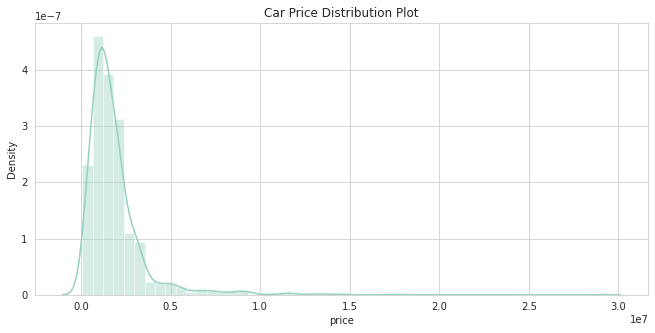

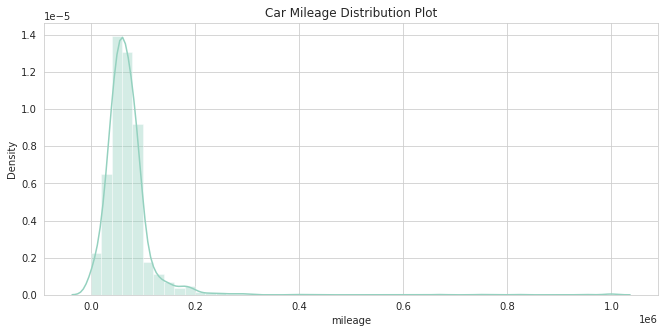

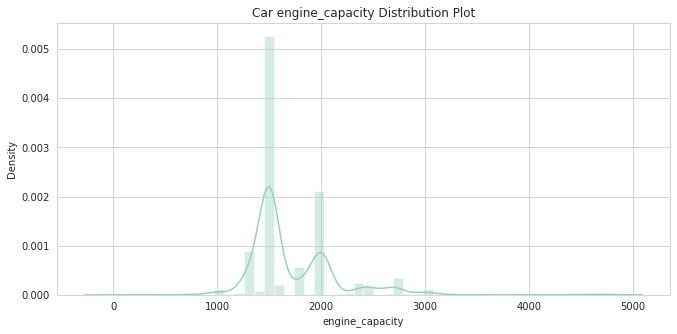

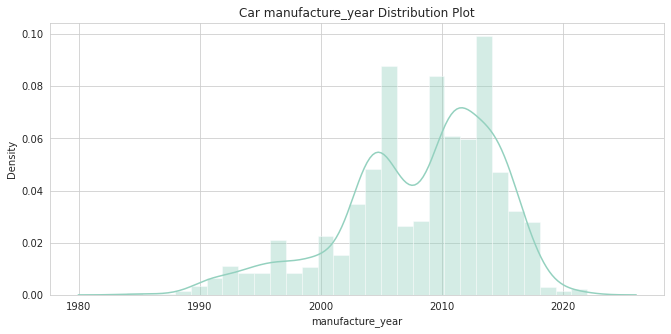

In [551]:
###-----car price---------
plt.figure(figsize=[11,5])
sns.distplot(updated_df['price'])
plt.title('Car Price Distribution Plot')

###-----mileage---------
plt.figure(figsize=[11,5])
sns.distplot(updated_df['mileage'])
plt.title('Car Mileage Distribution Plot')

###-----engine capacity---------
plt.figure(figsize=[11,5])
sns.distplot(updated_df['engine_capacity'])
plt.title('Car engine_capacity Distribution Plot')

###-----car manufacture year---------
plt.figure(figsize=[11,5])
sns.distplot(updated_df['manufacture_year'])
plt.title('Car manufacture_year Distribution Plot')

# Dealing with outliers

In [552]:
updated_df.describe()

,manufacture_year,engine_capacity,mileage,price
count,2414.000000,2414.000000,2414.000000,2.414000e+03
mean,2008.135460,1725.514085,69434.547639,1.864540e+06
std,6.402209,458.162205,56868.804624,1.760469e+06
min,1984.000000,15.000000,0.000000,8.000000e+04
25%,2004.000000,1500.000000,46000.000000,9.500000e+05
50%,2010.000000,1500.000000,63944.000000,1.430000e+06
75%,2013.000000,2000.000000,84091.000000,2.180000e+06
max,2022.000000,4800.000000,1000000.000000,2.900000e+07


In [553]:
###define a outlier function using IQR
def outliers(df ,column):
  Q1= df[column].quantile(0.25) 
  Q3= df[column].quantile(0.75)
  IQR=Q3-Q1
  lower_bound=Q1-(1.5*IQR) 
  upper_bound=Q3+(1.5*IQR)

  list=df.index[(df[column]<lower_bound) | (df[column]>upper_bound)]
  return list 

In [554]:
### define a list to store the outlier's row number
outliers_list=[]
for feature in ['manufacture_year','engine_capacity','mileage','price']:
  outliers_list.extend(outliers(updated_df,feature))

len(outliers_list) 

337

In [555]:
###define a remove function that will remove the outlier row and returen a new cleaned dataframe

def remove (df,list):
  list=sorted(set(list))
  df=df.drop(list)
  return df



In [556]:
### clean dataframe without outliers
updated_df2=remove(updated_df,outliers_list)
updated_df2.shape

(2106, 10)

# Check data distribution  after removing outliers 

Text(0.5, 1.0, 'Car manufacture_year Distribution Plot after removing outliers')

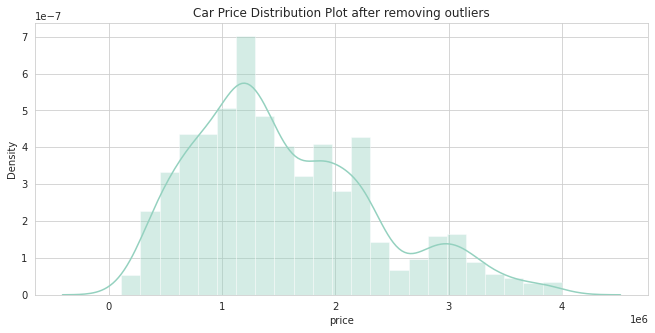

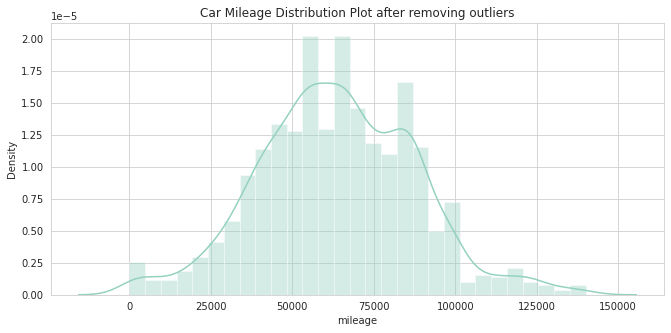

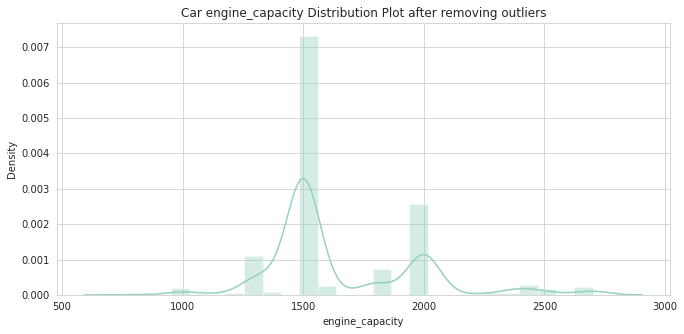

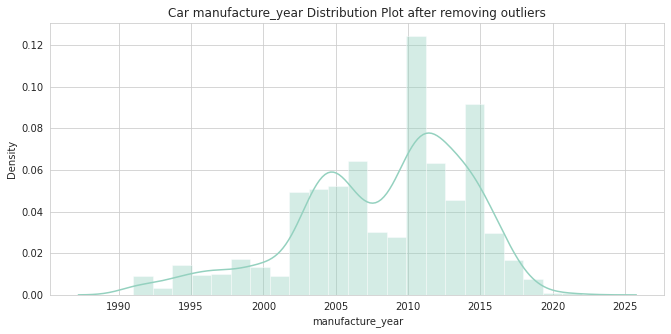

In [557]:
###-----car price---------
plt.figure(figsize=[11,5])
sns.distplot(updated_df2['price'])
plt.title('Car Price Distribution Plot after removing outliers')

###-----mileage---------
plt.figure(figsize=[11,5])
sns.distplot(updated_df2['mileage'])
plt.title('Car Mileage Distribution Plot after removing outliers')

###-----engine capacity---------
plt.figure(figsize=[11,5])
sns.distplot(updated_df2['engine_capacity'])
plt.title('Car engine_capacity Distribution Plot after removing outliers')

###-----car manufacture year---------
plt.figure(figsize=[11,5])
sns.distplot(updated_df2['manufacture_year'])
plt.title('Car manufacture_year Distribution Plot after removing outliers')

In [558]:
updated_df2.describe()

,manufacture_year,engine_capacity,mileage,price
count,2106.000000,2106.000000,2106.000000,2.106000e+03
mean,2008.288224,1652.054606,63836.123457,1.544320e+06
std,5.839746,317.680699,24099.494288,7.985558e+05
min,1991.000000,800.000000,0.000000,1.100000e+05
25%,2004.000000,1500.000000,48000.000000,9.550000e+05
50%,2010.000000,1500.000000,64000.000000,1.380000e+06
75%,2013.000000,2000.000000,80000.000000,2.045000e+06
max,2022.000000,2700.000000,140000.000000,4.000000e+06


# Data exploration and correlation using Scatter plot


In [559]:
updated_df2.corr()

,manufacture_year,engine_capacity,mileage,price
manufacture_year,1.000000,0.027555,-0.523876,0.697381
engine_capacity,0.027555,1.000000,-0.026719,0.425140
mileage,-0.523876,-0.026719,1.000000,-0.490851
price,0.697381,0.425140,-0.490851,1.000000


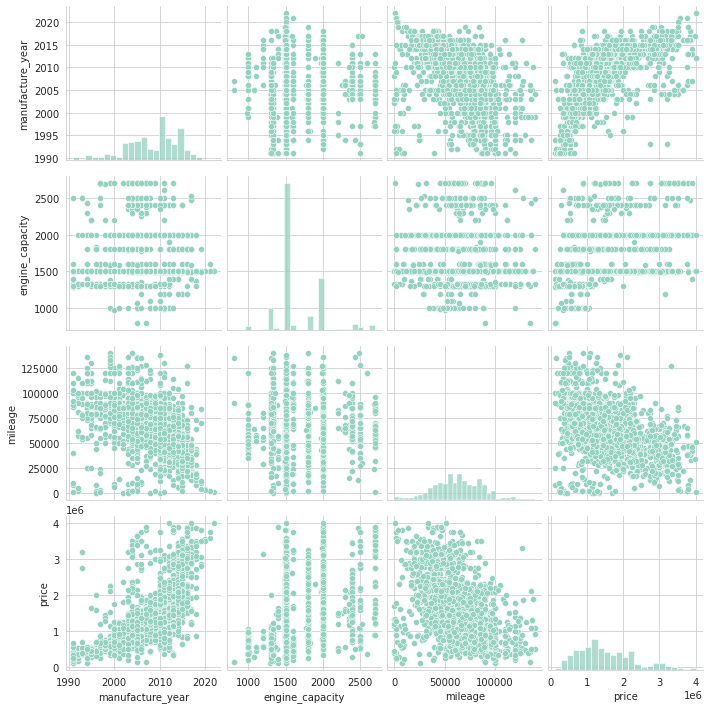

In [560]:
sns.pairplot(updated_df2)

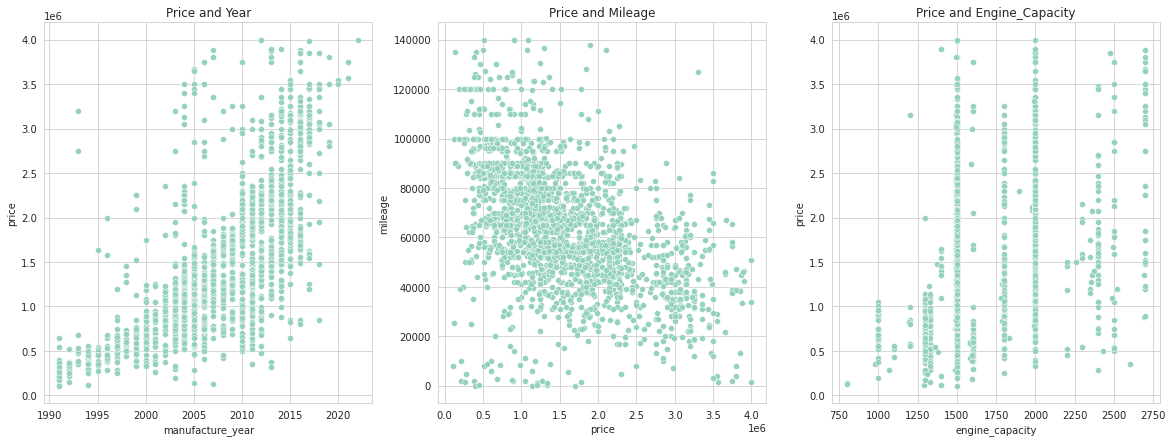

In [561]:
#Scatter Plot of independent variables vs dependent variables
plt.figure(figsize=[20,7])
plt.subplot(1,3,1)
plt.title("Price and Year")
sns.scatterplot(x='manufacture_year',y='price',data=updated_df2)

plt.subplot(1,3,2)
plt.title("Price and Mileage")
sns.scatterplot(x='price',y='mileage',data=updated_df2)

plt.subplot(1,3,3)
plt.title("Price and Engine_Capacity")
sns.scatterplot(y='price',x='engine_capacity',data=updated_df2)

# Log transformation

In [562]:
# Let's transform 'Price' with a log transformation
log_price = np.log(updated_df2['price'])

# Then we add it to our data frame
updated_df2['log_price'] = log_price
updated_df2.head()

,brand,model,manufacture_year,condition,transmission,body_type,fuel_type,engine_capacity,mileage,price,log_price
0,Toyota,Premio,2015,Used,Automatic,Saloon,Octane,1500,52000,2600000,14.771022
1,Toyota,Allion,2015,Used,Automatic,Saloon,Petrol,1500,36900,1380000,14.137594
2,Toyota,Premio,2018,Used,Automatic,Saloon,Octane,1496,28000,3050000,14.930652
3,Toyota,Allion,2012,Used,Automatic,Saloon,"Petrol, Octane",1500,49879,1900000,14.457364
4,Toyota,Corolla,2003,Used,Automatic,Saloon,"CNG, Octane",1500,8500,980000,13.795308


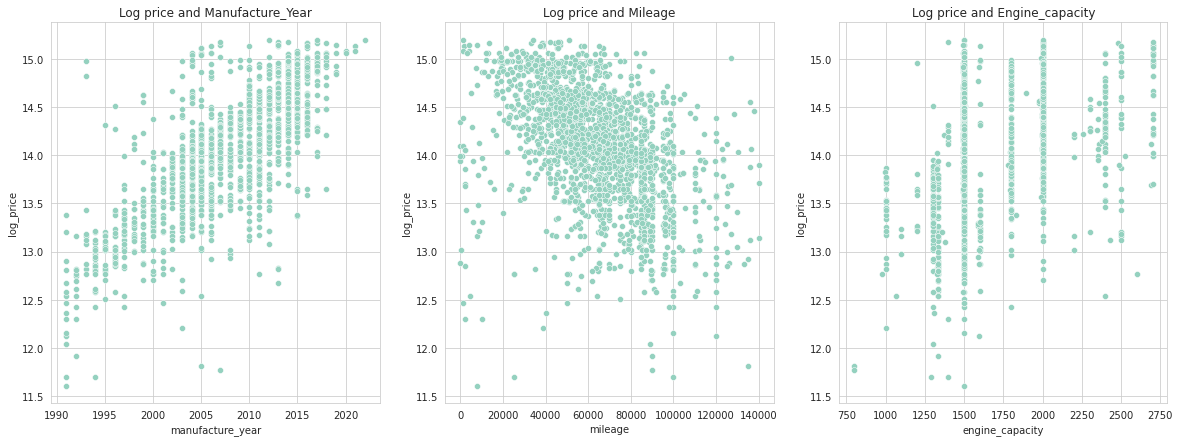

In [563]:
# Let's check the three scatters once again

plt.figure(figsize=[20,7])
plt.subplot(1,3,1)
plt.title("Log price and Manufacture_Year")
sns.scatterplot(x='manufacture_year',y='log_price',data=updated_df2)

plt.subplot(1,3,2)
plt.title("Log price and Mileage")
sns.scatterplot(y='log_price',x='mileage',data=updated_df2)

plt.subplot(1,3,3)
plt.title("Log price and Engine_capacity")
sns.scatterplot(y='log_price',x='engine_capacity',data=updated_df2)



In [564]:
updated_df3=updated_df2.drop('price',axis='columns')
updated_df3.head()

,brand,model,manufacture_year,condition,transmission,body_type,fuel_type,engine_capacity,mileage,log_price
0,Toyota,Premio,2015,Used,Automatic,Saloon,Octane,1500,52000,14.771022
1,Toyota,Allion,2015,Used,Automatic,Saloon,Petrol,1500,36900,14.137594
2,Toyota,Premio,2018,Used,Automatic,Saloon,Octane,1496,28000,14.930652
3,Toyota,Allion,2012,Used,Automatic,Saloon,"Petrol, Octane",1500,49879,14.457364
4,Toyota,Corolla,2003,Used,Automatic,Saloon,"CNG, Octane",1500,8500,13.795308


#Feature Selection


In [565]:
temp_data = updated_df3.copy()
for col in temp_data.columns:
    if temp_data[col].dtypes == 'object':
        encoder = LabelEncoder()
        temp_data[col] = encoder.fit_transform(temp_data[col])
print(abs(temp_data.corrwith(temp_data['log_price'])).sort_values(ascending=False)[1:])

manufacture_year    0.765967
mileage             0.467079
engine_capacity     0.404861
fuel_type           0.297074
transmission        0.214463
brand               0.189585
body_type           0.100448
model               0.079880
condition           0.079584
dtype: float64


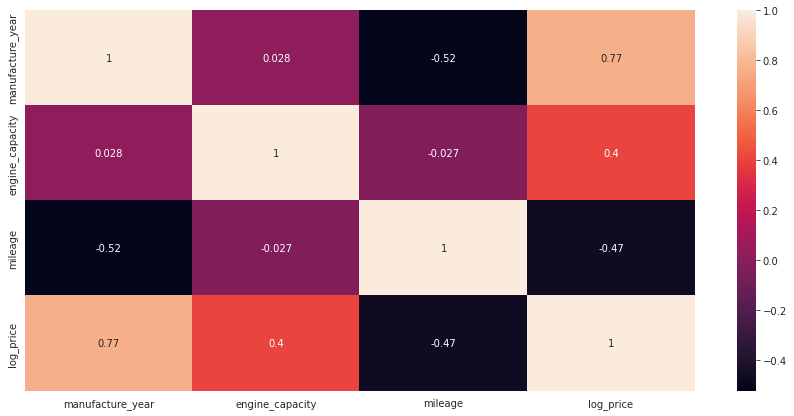

In [566]:
plt.figure(figsize=[15,7])
sns.heatmap(updated_df3.corr(), annot=True)

# Feature Importance

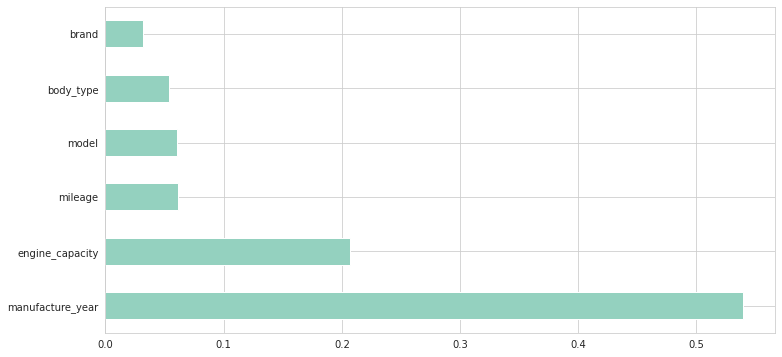

In [567]:
X = temp_data.drop('log_price',axis=1)
y = temp_data['log_price']
model = ExtraTreesRegressor()
model.fit(X,y)

plt.figure(figsize=[12,6])
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(6).plot(kind='barh')
plt.show()

# Categorical features

In [568]:
###--------Condition-------------------
print(updated_df3.condition.unique())

enc=LabelEncoder()
updated_df3['condition']=enc.fit_transform(updated_df3['condition'])
updated_df3.head()

['Used' 'Reconditioned']


,brand,model,manufacture_year,condition,transmission,body_type,fuel_type,engine_capacity,mileage,log_price
0,Toyota,Premio,2015,1,Automatic,Saloon,Octane,1500,52000,14.771022
1,Toyota,Allion,2015,1,Automatic,Saloon,Petrol,1500,36900,14.137594
2,Toyota,Premio,2018,1,Automatic,Saloon,Octane,1496,28000,14.930652
3,Toyota,Allion,2012,1,Automatic,Saloon,"Petrol, Octane",1500,49879,14.457364
4,Toyota,Corolla,2003,1,Automatic,Saloon,"CNG, Octane",1500,8500,13.795308


In [569]:
###--------Transmission-------------------
print(updated_df3.transmission.unique())

#delete 'Other transmission' value
transmission_extra = updated_df3[updated_df3['transmission'].str.contains('Other transmission')]

updated_df3 = updated_df3.drop(labels=1983, axis=0)



updated_df3['transmission']=enc.fit_transform(updated_df3['transmission'])
updated_df3.transmission.shape

['Automatic' 'Manual' 'Other transmission']


(2105,)

In [570]:
###--------------body_type-----------------------
print(updated_df3.body_type.unique())
count_bodyType=updated_df3.groupby('body_type')['body_type'].agg('count')
# print(count_bodyType)





#one hot encoding
body_type_columns=updated_df3["body_type"].str.get_dummies()


updated_df3=pd.concat([updated_df3,body_type_columns],axis='columns')
updated_df3=updated_df3.drop('body_type',axis='columns')
print(updated_df3.head())


['Saloon' 'SUV / 4x4' 'Hatchback' 'MPV' 'Estate' 'Convertible'
 'Coupé/Sports']
    brand    model  manufacture_year  condition  transmission       fuel_type  \
0  Toyota   Premio              2015          1             0          Octane   
1  Toyota   Allion              2015          1             0          Petrol   
2  Toyota   Premio              2018          1             0          Octane   
3  Toyota   Allion              2012          1             0  Petrol, Octane   
4  Toyota  Corolla              2003          1             0     CNG, Octane   

   engine_capacity  mileage  log_price  Convertible  Coupé/Sports  Estate  \
0             1500    52000  14.771022            0             0       0   
1             1500    36900  14.137594            0             0       0   
2             1496    28000  14.930652            0             0       0   
3             1500    49879  14.457364            0             0       0   
4             1500     8500  13.795308          

In [571]:
###------------fuel type---------------
print(updated_df3.fuel_type.unique())

#delete 'other type fuel' value
fuel_type_extra = updated_df3[updated_df3['fuel_type'].str.contains('Other fuel type')]
print(fuel_type_extra)
updated_df3 = updated_df3.drop(labels=2084, axis=0)


#one_hot_encoding
fuel_type_columns=updated_df3["fuel_type"].str.get_dummies(", ")
print(fuel_type_columns.head())


updated_df3=pd.concat([updated_df3,fuel_type_columns],axis='columns')
updated_df3=updated_df3.drop('fuel_type',axis='columns')
print(updated_df.head())

['Octane' 'Petrol' 'Petrol, Octane' 'CNG, Octane' 'Octane, LPG'
 'Petrol, CNG, Octane' 'Petrol, CNG' 'CNG' 'Diesel' 'Hybrid, Octane'
 'Petrol, Hybrid, Octane' 'Petrol, Octane, LPG' 'Petrol, Hybrid' 'LPG'
 'Hybrid' 'Petrol, LPG' 'Electric, Octane' 'Diesel, Octane'
 'CNG, Other fuel type' 'Petrol, Hybrid, Electric, Octane'
 'Hybrid, Electric']
       brand           model  manufacture_year  condition  transmission  \
2084  Toyota  Starlet Soleil              1991          1             0   

                 fuel_type  engine_capacity  mileage  log_price  Convertible  \
2084  CNG, Other fuel type             1400    10000  12.301383            0   

      Coupé/Sports  Estate  Hatchback  MPV  SUV / 4x4  Saloon  
2084             0       0          0    0          0       1  
   CNG  Diesel  Electric  Hybrid  LPG  Octane  Petrol
0    0       0         0       0    0       1       0
1    0       0         0       0    0       0       1
2    0       0         0       0    0       1       0


In [572]:
###-------------Brand-------------------------------
# updated_df3.brand.unique()


#one hot encoding
brand_columns=updated_df3["brand"].str.get_dummies()



updated_df3=pd.concat([brand_columns,updated_df3],axis='columns')
updated_df3=updated_df3.drop('brand',axis='columns')


In [573]:
###-------------model-----------------------


# #one hot encoding
model_columns=updated_df3["model"].str.get_dummies()



updated_df3=pd.concat([model_columns,updated_df3],axis='columns')
updated_df3=updated_df3.drop('model',axis='columns')


## Model Development

In [574]:
###------------creating feature and lael
print(updated_df3.head(50))
features = updated_df3.drop('log_price',axis=1)
label = updated_df3['log_price'] 


print(features.shape)
print(label.shape)


    2000GT  320i  5 Series  523i  525i  800  86  APV  ASX  Aent  ...  MPV  \
0        0     0         0     0     0    0   0    0    0     0  ...    0   
1        0     0         0     0     0    0   0    0    0     0  ...    0   
2        0     0         0     0     0    0   0    0    0     0  ...    0   
3        0     0         0     0     0    0   0    0    0     0  ...    0   
4        0     0         0     0     0    0   0    0    0     0  ...    0   
5        0     0         0     0     0    0   0    0    0     0  ...    0   
6        0     0         0     0     0    0   0    0    0     0  ...    0   
7        0     0         0     0     0    0   0    0    0     0  ...    0   
8        0     0         0     0     0    0   0    0    0     0  ...    0   
9        0     0         0     0     0    0   0    0    0     0  ...    1   
10       0     0         0     0     0    0   0    0    0     0  ...    0   
11       0     0         0     0     0    0   0    0    0     0  ...    0   

In [575]:
###-----------feature scaling using minmax scaling-----
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled=scaler.fit_transform(features)



In [576]:
###----------------train and test spliting----------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_scaled,label,test_size=0.2, random_state=500)

print(X_train)
print(y_train)




[[-0.03084598 -0.02180622 -0.02180622 ... -0.22571896  0.27206131
  -0.4702403 ]
 [-0.03084598 -0.02180622 -0.02180622 ... -0.22571896  0.27206131
  -0.4702403 ]
 [-0.03084598 -0.02180622 -0.02180622 ... -0.22571896  0.27206131
   2.12657229]
 ...
 [-0.03084598 -0.02180622 -0.02180622 ... -0.22571896  0.27206131
  -0.4702403 ]
 [-0.03084598 -0.02180622 -0.02180622 ... -0.22571896  0.27206131
  -0.4702403 ]
 [-0.03084598 -0.02180622 -0.02180622 ... -0.22571896  0.27206131
  -0.4702403 ]]
713     13.270783
2115    14.430696
1238    14.943682
157     14.100690
1020    13.296317
          ...    
976     14.400516
679     14.070153
334     14.569282
317     14.862830
1092    14.483340
Name: log_price, Length: 1683, dtype: float64


In [577]:
# Random Forest Regressor Model Building
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()



rf.fit(X_train,y_train)


rf_prediction = rf.predict(X_test)

rf_accuracy = r2_score(y_test,rf_prediction)*100


print(f'Random Forest accuracy is {rf_accuracy}%')






Random Forest accuracy is 90.54127602475099%


In [578]:
# Gradiant Boosting Model Building
from sklearn.ensemble import GradientBoostingRegressor
gbt = GradientBoostingRegressor()


gbt.fit(X_train,y_train)


gbt_prediction = gbt.predict(X_test)

gbt_accuracy =r2_score(y_test,gbt_prediction)*100

print(f'Gradiant boosting accuracy is {gbt_accuracy}%')




Gradiant boosting accuracy is 89.02961989991464%


In [579]:
#neural network
from sklearn.neural_network import MLPClassifier
neural_nc_model=MLPClassifier(hidden_layer_sizes=(7), activation="relu", max_iter=10000)
y_train_int=y_train.astype(int)
y_test_int=y_test.astype(int)
neural_nc_model.fit(X_train, y_train_int)

nnc_predictions = neural_nc_model.predict(X_test)

nnc_acc = accuracy_score(y_test_int, nnc_predictions)*100
print(f'Neural Network (MLPClassifier) Accuracy is {nnc_acc}%')

Neural Network (MLPClassifier) Accuracy is 87.88598574821853%


In [580]:
# svc model
from sklearn.svm import SVC
svc= SVC(kernel="linear")
y_train_int=y_train.astype(int)
y_test_int=y_test.astype(int)
svc.fit(X_train, y_train_int)

svc_prediction= svc.predict(X_test)

svc_accuracy = accuracy_score(y_test_int, svc_prediction)*100
print(f'SVC accuracy is {svc_accuracy}%')

SVC accuracy is 87.17339667458432%
